In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

# jupyter配置
pd.options.display.max_rows=1000 #Notebook 的一个cell的显示行数
pd.options.display.max_columns=10000#Notebook 的一个cell的显示列数

In [210]:
# 读取训练数据
train_data_x = np.load('./train_data/train_x.npy')
train_data_y = np.load('./train_data/train_y.npy')
# 读取测试数据
test_x_A = np.load("./test_data/test_x_A.npy")

# 这里先做做一个简易版，先把两个观测指标片接到一起，即每个样本特征是180+180长度
train_data_x_reshape = train_data_x.reshape(train_data_x.shape[0], -1)
test_x_A_reshape = test_x_A.reshape(test_x_A.shape[0], -1)

df_train_data_x = pd.DataFrame(train_data_x_reshape)
df_train_data_y = pd.DataFrame(train_data_y).squeeze()
df_test_data_x = pd.DataFrame(test_x_A_reshape)

# 最大值最小值
train_max_oxygen = df_train_data_x.iloc[:,:180].max(axis=1).values.reshape(-1, 1)
train_min_oxygen = df_train_data_x.iloc[:,:180].min(axis=1).values.reshape(-1, 1)
train_max_heart = df_train_data_x.iloc[:,180:].max(axis=1).values.reshape(-1, 1)
train_min_heart = df_train_data_x.iloc[:,180:].min(axis=1).values.reshape(-1, 1)

test_max_oxygen = df_test_data_x.iloc[:,:180].max(axis=1).values.reshape(-1, 1)
test_min_oxygen = df_test_data_x.iloc[:,:180].min(axis=1).values.reshape(-1, 1)
test_max_heart = df_test_data_x.iloc[:,180:].max(axis=1).values.reshape(-1, 1)
test_min_heart = df_test_data_x.iloc[:,180:].min(axis=1).values.reshape(-1, 1)

# 平均值
train_mean_oxygen = df_train_data_x.iloc[:,:180].mean(axis=1).values.reshape(-1, 1)
train_mean_heart = df_train_data_x.iloc[:,180:].mean(axis=1).values.reshape(-1, 1)

test_mean_oxygen = df_test_data_x.iloc[:,:180].mean(axis=1).values.reshape(-1, 1)
test_mean_heart = df_test_data_x.iloc[:,180:].mean(axis=1).values.reshape(-1, 1)

# 标准差和方差
train_std_oxygen = df_train_data_x.iloc[:,:180].std(axis=1).values.reshape(-1, 1)
train_std_heart = df_train_data_x.iloc[:,180:].std(axis=1).values.reshape(-1, 1)
train_var_oxygen = df_train_data_x.iloc[:,:180].var(axis=1).values.reshape(-1, 1)
train_var_heart = df_train_data_x.iloc[:,180:].var(axis=1).values.reshape(-1, 1)

test_std_oxygen = df_test_data_x.iloc[:,:180].std(axis=1).values.reshape(-1, 1)
test_std_heart = df_test_data_x.iloc[:,180:].std(axis=1).values.reshape(-1, 1)
test_var_oxygen = df_test_data_x.iloc[:,:180].var(axis=1).values.reshape(-1, 1)
test_var_heart = df_test_data_x.iloc[:,180:].var(axis=1).values.reshape(-1, 1)

train_statistic_name = ["max_oxygen", "min_oxygen", "max_heart", "min_heart", "mean_oxygen", "mean_heart", "std_oxygen", "std_heart", "var_oxygen", "var_heart"]

train_statistic = np.concatenate((train_max_oxygen, train_min_oxygen, train_max_heart, train_min_heart, train_mean_oxygen, train_mean_heart, train_std_oxygen, train_std_heart,
                                train_var_oxygen, train_var_heart), axis=1)

test_statistic = np.concatenate((test_max_oxygen, test_min_oxygen, test_max_heart, test_min_heart, test_mean_oxygen, test_mean_heart, test_std_oxygen, test_std_heart,
                                test_var_oxygen, test_var_heart), axis=1)

train_statistic = pd.DataFrame(train_statistic, columns=train_statistic_name)
test_statistic = pd.DataFrame(test_statistic, columns=train_statistic_name)



In [241]:
df_train_data_x.iloc[:, 0:0+30].max(axis=1).values.reshape(-1, 1).shape

(37549, 1)

In [278]:
# 统计每5秒钟的数据统计特征
interval = 5 * 3
per_5s = np.empty((train_data_x_reshape.shape[0], 1))
per_5s_feat_name = []
for i in range(0, train_data_x_reshape.shape[1],interval):
    per_5s = np.concatenate((per_5s, df_train_data_x.iloc[:, i:i+interval].max(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].min(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].mean(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].std(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].var(axis=1).values.reshape(-1, 1)), axis=1)
    per_5s_feat_name.extend([f"per_5s_{i}_{i+interval}_max", f"per_5s_{i}_{i+interval}_min", f"per_5s_{i}_{i+interval}_mean", f"per_5s_{i}_{i+interval}_std", f"per_5s_{i}_{i+interval}_var"])
per_5s = pd.DataFrame(per_5s[:,1:])

# 统计每10秒钟的数 * 3
per_10s = np.empty((train_data_x_reshape.shape[0], 1))
per_10s_feat_name = []
for i in range(0, train_data_x_reshape.shape[1],30):
    per_10s = np.concatenate((per_10s, df_train_data_x.iloc[:, i:i+interval].max(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].min(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].mean(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].std(axis=1).values.reshape(-1, 1),
                              df_train_data_x.iloc[:, i:i+interval].var(axis=1).values.reshape(-1, 1)), axis=1)
    per_10s_feat_name.extend([f"per_5s_{i}_{i+interval}_max", f"per_5s_{i}_{i+interval}_min", f"per_5s_{i}_{i+interval}_mean", f"per_5s_{i}_{i+interval}_std", f"per_5s_{i}_{i+interval}_var"])
per_10s = pd.DataFrame(per_10s[:,1:])


['per_5s_0_15_max', 'per_5s_0_15_min', 'per_5s_0_15_mean', 'per_5s_0_15_std', 'per_5s_0_15_var', 'per_5s_15_30_max', 'per_5s_15_30_min', 'per_5s_15_30_mean', 'per_5s_15_30_std', 'per_5s_15_30_var', 'per_5s_30_45_max', 'per_5s_30_45_min', 'per_5s_30_45_mean', 'per_5s_30_45_std', 'per_5s_30_45_var', 'per_5s_45_60_max', 'per_5s_45_60_min', 'per_5s_45_60_mean', 'per_5s_45_60_std', 'per_5s_45_60_var', 'per_5s_60_75_max', 'per_5s_60_75_min', 'per_5s_60_75_mean', 'per_5s_60_75_std', 'per_5s_60_75_var', 'per_5s_75_90_max', 'per_5s_75_90_min', 'per_5s_75_90_mean', 'per_5s_75_90_std', 'per_5s_75_90_var', 'per_5s_90_105_max', 'per_5s_90_105_min', 'per_5s_90_105_mean', 'per_5s_90_105_std', 'per_5s_90_105_var', 'per_5s_105_120_max', 'per_5s_105_120_min', 'per_5s_105_120_mean', 'per_5s_105_120_std', 'per_5s_105_120_var', 'per_5s_120_135_max', 'per_5s_120_135_min', 'per_5s_120_135_mean', 'per_5s_120_135_std', 'per_5s_120_135_var', 'per_5s_135_150_max', 'per_5s_135_150_min', 'per_5s_135_150_mean', 'pe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,96.0,96.0,96.000000,0.000000,0.000000,95.0,95.0,95.000000,0.000000,0.000000,95.0,94.0,94.133333,0.351866,0.123810,94.0,94.0,94.000000,0.000000,0.000000,95.0,94.0,94.666667,0.487950,0.238095,96.0,96.0,96.000000,0.000000,0.000000,67.0,46.0,63.466667,5.804760,33.695238,70.0,62.0,66.333333,2.439750,5.952381,89.0,69.0,74.200000,5.466783,29.885714,71.0,58.0,60.400000,3.680062,13.542857,78.0,61.0,68.933333,4.333700,18.780952,92.0,50.0,67.133333,10.855326,117.838095
1,95.0,94.0,94.066667,0.258199,0.066667,95.0,95.0,95.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,96.0,95.0,95.266667,0.457738,0.209524,96.0,95.0,95.733333,0.457738,0.209524,64.0,48.0,55.533333,5.370111,28.838095,84.0,58.0,65.733333,6.540715,42.780952,69.0,64.0,66.533333,1.505545,2.266667,73.0,63.0,66.866667,2.799660,7.838095,100.0,60.0,77.133333,14.932547,222.980952,100.0,55.0,91.200000,14.138094,199.885714
2,96.0,95.0,95.733333,0.457738,0.209524,95.0,94.0,94.866667,0.351866,0.123810,96.0,95.0,95.266667,0.457738,0.209524,95.0,95.0,95.000000,0.000000,0.000000,95.0,94.0,94.533333,0.516398,0.266667,95.0,94.0,94.066667,0.258199,0.066667,94.0,90.0,91.866667,1.187234,1.409524,86.0,83.0,84.600000,1.121224,1.257143,79.0,76.0,77.266667,1.032796,1.066667,72.0,68.0,69.866667,1.187234,1.409524,64.0,61.0,62.600000,1.121224,1.257143,57.0,54.0,55.333333,1.046536,1.095238
3,95.0,95.0,95.000000,0.000000,0.000000,95.0,95.0,95.000000,0.000000,0.000000,95.0,95.0,95.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,94.0,93.0,93.266667,0.457738,0.209524,95.0,95.0,95.000000,0.000000,0.000000,95.0,50.0,74.933333,13.781285,189.923810,100.0,60.0,85.866667,14.652482,214.695238,100.0,52.0,79.866667,17.569725,308.695238,99.0,56.0,85.200000,13.213629,174.600000,100.0,68.0,91.600000,10.126345,102.542857,100.0,82.0,93.333333,6.553807,42.952381
4,95.0,95.0,95.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,95.0,94.0,94.466667,0.516398,0.266667,96.0,96.0,96.000000,0.000000,0.000000,95.0,94.0,94.733333,0.457738,0.209524,95.0,95.0,95.000000,0.000000,0.000000,100.0,72.0,88.600000,10.076848,101.542857,75.0,57.0,62.933333,5.324695,28.352381,71.0,61.0,67.000000,2.751623,7.571429,81.0,62.0,71.333333,5.136239,26.380952,96.0,72.0,84.800000,5.882176,34.600000,93.0,56.0,78.133333,10.947059,119.838095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37544,96.0,96.0,96.000000,0.000000,0.000000,96.0,96.0,96.000000,0.000000,0.000000,96.0,95.0,95.933333,0.258199,0.066667,96.0,95.0,95.066667,0.258199,0.066667,96.0,95.0,95.200000,0.414039,0.171429,98.0,94.0,94.933333,1.334523,1.780952,54.0,52.0,52.666667,0.723747,0.523810,58.0,55.0,57.066667,1.099784,1.209524,59.0,57.0,57.866667,0.990430,0.980952,65.0,61.0,63.133333,1.355764,1.838095,65.0,65.0,65.000000,0.000000,0.000000,40.0,40.0,40.000000,0.000000,0.000000
37545,95.0,94.0,94.800000,0.414039,0.171429,95.0,94.0,94.066667,0.258199,0.066667,94.0,94.0,94.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,94.0,94.0,94.000000,0.000000,0.000000,94.0,93.0,93.400000,0.507093,0.257143,65.0,65.0,65.000000,0.000000,0.000000,65.0,65.0,65.000000,0.000000,0.000000,65.0,65.0,65.000000,0.000000,0.000000,65.0,65.0,65.000000,0.000000,0.000000,65.0,65.0,65.000000,0.000000,0.000000,65.0,65.0,65.000000,0.000000,0.000000
37546,93.0,93.0,93.000000,0.000000,0.000000,93.0,93.0,93.000000,0.000000,0.000000,93.0,93.0,93.000000,0.000000,0.000000,93.0,92.0,92.733333,0.457738,0.209524,92.0,92.0,92.000000,0.000000,0.000000,92.0,92.0,92.000000,0.000000,0.000000,66.0,65.0,65.733333,0.457738,0.209524,66.0,66.0,66.000000,0.000000,0.000000,66.0,66.0,66.0

In [211]:
feat_name = [f'oxygen_{x}' for x in range(180)] + [f'heart_{x}' for x in range(180)] + train_statistic_name + [per_5s_feat_name, per_10s_feat_name]
train_data = pd.concat((df_train_data_x, train_statistic, ), names=feat_name, axis=1)
test_submit = pd.concat((df_test_data_x, test_statistic), names=feat_name, axis=1)

# Min-Max 归一化
train_data_normalized = (train_data - train_data.min()) / (train_data.max() - train_data.min())
test_submit_normalized = (test_submit - test_submit.min()) / (test_submit.max() - test_submit.min())

print(test_submit_normalized)
X_train_val, X_test, y_train_val, y_test = train_test_split(train_data_normalized.values, df_train_data_y.values, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

# 将数据转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_val_tensor = torch.tensor(y_val)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test)

submit_tensor = torch.tensor(test_submit_normalized.values, dtype=torch.float)


# 创建TensorDataset和DataLoader
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# print("train_x.shape", X_train_val.shape)
# print("test_x.shape", X_test.shape)
# print("train_y.shape", y_train_val.shape)
# print("test_y.shape", y_test.shape)
# print("X_val.shape", X_val.shape)
# print("y_val.shape", y_val.shape)
# print("X_train.shape", X_train.shape)
# print("y_train.shape", y_train.shape)
# print("submit_tensor.shape", submit_tensor.shape)

             0         1         2         3         4         5         6  \
0     0.785714  0.785714  0.785714  0.785714  0.785714  0.785714  0.785714   
1     0.785714  0.785714  0.785714  0.750000  0.750000  0.750000  0.750000   
2     0.714286  0.714286  0.714286  0.678571  0.678571  0.678571  0.678571   
3     0.785714  0.785714  0.785714  0.785714  0.785714  0.785714  0.785714   
4     0.750000  0.750000  0.750000  0.821429  0.821429  0.821429  0.821429   
...        ...       ...       ...       ...       ...       ...       ...   
1150  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286   
1151  0.857143  0.857143  0.857143  0.857143  0.857143  0.857143  0.857143   
1152  0.821429  0.857143  0.857143  0.857143  0.821429  0.821429  0.821429   
1153  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286   
1154  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286  0.964286   

             7         8         9        10        11        1

In [212]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_calsses) -> None:
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_calsses)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# 模型训练
input_size = X_train.shape[-1]
hidden_size = 64
num_classes = 3
model = SimpleNN(input_size, hidden_size, num_classes)
num_epochs  = 1000

# 定义损失函数和优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    model.eval()  # 设置为评估模式
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# 在测试集上评估模型
model.eval()  # 设置为评估模式
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
    test_accuracy = 100 * test_correct / test_total
    print(f'Final Test Accuracy: {test_accuracy:.2f}%')

In [215]:
#预测test
model.eval()  # 设置为评估模式
with torch.no_grad():
    outputs = model(submit_tensor)
    _, predicted = torch.max(outputs, 1)
df_submit = predicted.numpy()
submit = pd.DataFrame({'id':range(len(df_submit)), 'label':df_submit}).astype('int32')
submit.to_csv(f"/Users/wzq/Desktop/game/DetectionOfSleep/submit/submit_example_A{time.strftime('%Y%m%d%H%M', time.localtime())}.csv",index=False, encoding='utf-8')

submit


,id,label
0,0,0
1,1,2
2,2,1
3,3,0
4,4,1
...,...,...
1150,1150,1
1151,1151,0
1152,1152,0
1153,1153,0


(37549, 180)


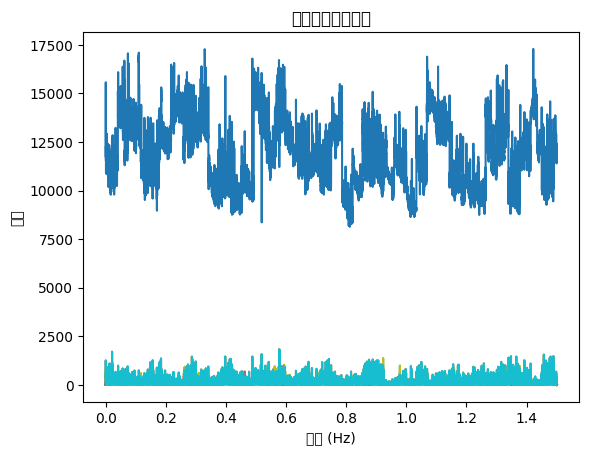

In [272]:
# 快速傅里叶变换（FFT）
# FFT 是一种将时间域信号转换为频域信号的算法，它可以揭示信号中的周期成分。
from scipy.fft import fft, fftfreq
import matplotlib.pylab as plt

heart_rates = train_data_x[:,1,:]
print(heart_rates.shape)
# 计算心率信号的采样频率（假设心率数据每秒采样一次）
sampling_rate = 3  # 采样频率为1 Hz

# 计算FFT
N = len(heart_rates)
yf = fft(heart_rates)
xf = fftfreq(N, 1 / sampling_rate)

# 只取正频率部分
xf = xf[:N//2]
heart_fft = np.abs(yf[:N//2])

# 绘制频谱图
plt.plot(xf, heart_fft)
plt.title("心率信号的频谱图")
plt.xlabel("频率 (Hz)")
plt.ylabel("幅度")
plt.show()

In [226]:
# 感觉像是每个人10min的数据
37549 / 60 / 60       

10.430277777777778